# Regularized Logistic Regression Exercise Solution

### Background

Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests,you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data/ex2data2.txt', header=None, names=['test_one', 'test_two', 'accepted'])
data.shape

(118, 3)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test_one    118 non-null float64
test_two    118 non-null float64
accepted    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [4]:
data.head()

,test_one,test_two,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


We'll start by visualizing the data

Text(0, 0.5, 'Test 2 Score')

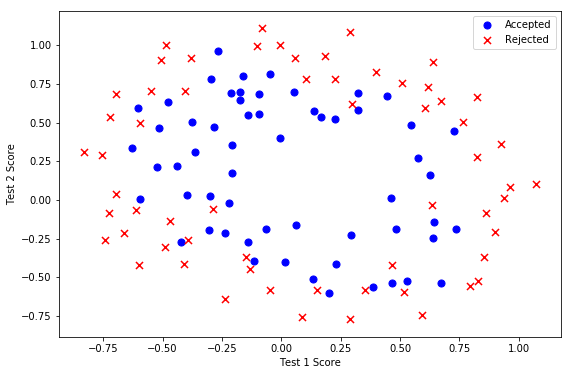

In [7]:
positive = data[data.accepted.isin([1])]
negative = data[data.accepted.isin([0])]

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(positive['test_one'], positive['test_two'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['test_one'], negative['test_two'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

There is no linear decision boundary in this data set. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. We can try creating a bunch of polynomial features to feed into the classifier.

In [8]:
degree = 5
x1 = data['test_one']
x2 = data['test_two']

data.insert(3, 'Ones', 1)

for i in range(1, degree):
    for j in range(0, i):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data.drop('test_one', axis=1, inplace=True)
data.drop('test_two', axis=1, inplace=True)

data.head()

,accepted,Ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


Now we'll modify the cost and gradient functions used in the previous exercise to include the regularization term. In each case, the regularizer is added on to the previous calculation.

In [9]:
def cost(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Notice that we’ve added a new variable called “reg” that is a function of the parameter values. As the parameters get larger, the penalization added to the cost function increases. Also note that we’ve added a new “learning rate” parameter to the function. This is also part of the regularization term in the equation. The learning rate gives us a new hyper-parameter that we can use to tune how much weight the regularization holds in the cost function.

The updated gradient function:

In [10]:
def gradient(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    
    return grad


Just as with the cost function, the regularization term is added on to the original calculation. However, unlike the cost function, we included logic to make sure that the first parameter is not regularized. The intuition behind this decision is that the first parameter is considered the “bias” or “intercept” of the model and shouldn’t be penalized.

To test our new functions:

In [12]:
# set X and y (remember from above that we moved the label to column 0)
cols = data.shape[1]
X = data.iloc[:,1:cols]
y = data.iloc[:,0:1]

# convert to numpy arrays and initalize the parameter array theta
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(11)

learningRate = 1

cost(theta, X, y, learningRate)

0.6931471805599454

Calculating the optimal parameters:

In [13]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y, learningRate))
result

(array([ 1.22702519e-04,  7.19894617e-05, -3.74156201e-04, -1.44256427e-04,
         2.93165088e-05, -5.64160786e-05, -1.02826485e-04, -2.83150432e-04,
         6.47297947e-07, -1.99697568e-04, -1.68479583e-05]), 96, 1)

Finally we'll calculate the predictions and accuracy of the model

In [14]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

theta_min = np.matrix(result[0])
predictions = predict(theta_min, X)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print('accuracy = {0}%'.format(accuracy))

accuracy = 77%
